In [ ]:
import numpy as np
import pandas as pd
from itertools import groupby
from operator import itemgetter
from dataclasses import dataclass
from typing import Tuple


from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable



2025-03-11 09:41:03.896937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 09:41:03.956377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 09:41:03.974005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 09:41:04.920534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dfres = pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/NotWindy/NotWindyMASigned.h5') ## HighRes

In [4]:
index = osc.get_index(dfres.odor,4.5)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_from_source_a*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign

In [5]:

def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

thres = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,thres)
index_nowhiff = get_index_nowhiff(dfres.odor,thres)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

# fdf.keys()

#### Calculate LT Whiff Statistics

(-30.0, 30.0)

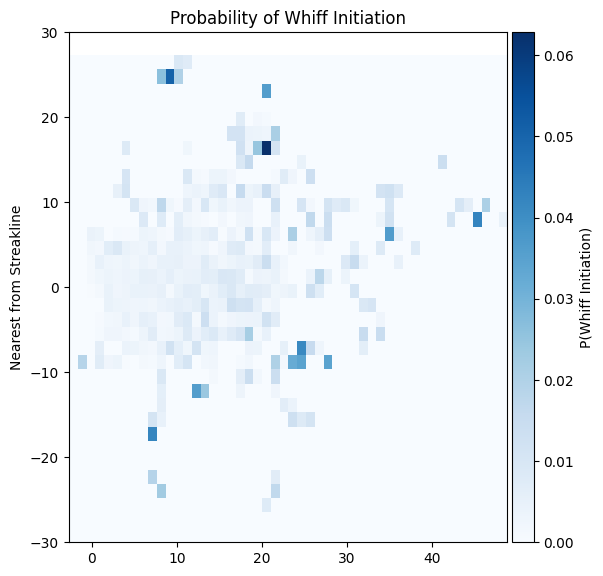

In [6]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_title('Probability of Whiff Initiation')
ax1.set_ylim(-30,30)
# ax1.set_xlim(-5,50)


Optimal Parameters:
A = 0.005145310196295027
x0 = 0.0
y0 = 0.0
sigma_y = 0.5
dy = 1.2
dist x = 0.010208519828055977


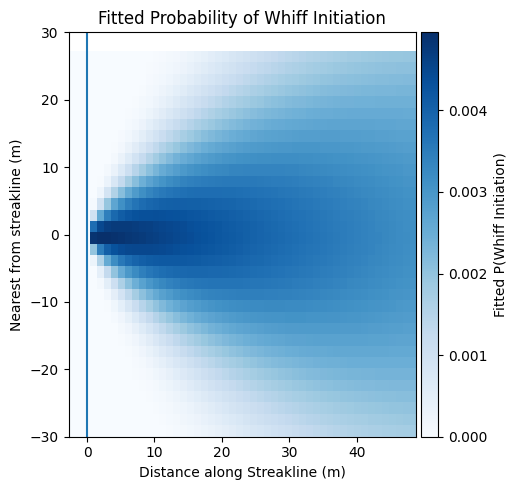

In [ ]:
# def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
#     distance_x = x - x0
#     distance_y = y - y0
#     # distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
#     # Simple sigma_y growth
#     sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)  # stronger growth with distance
    
#     # Basic Gaussian terms
#     gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
#     decay_term_x = np.exp(-decay_factor_x * distance_x)
    
#     return A * gaussian_y * decay_term_x

def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x):
    distance_x = x - x0
    distance_y = y - y0
    
    # Zero out negative x values
    mask_positive_x = distance_x >= 0
    
    # Adjust sigma_y with a smaller base value for finer resolution near y=0
    sigma_y = base_sigma_y + distance_scale_factor_y * np.power(np.abs(distance_x), 0.8)
    
    # Basic Gaussian terms
    gaussian_y = np.exp(-(distance_y**2) / (2 * sigma_y**2))
    decay_term_x = np.exp(-decay_factor_x * distance_x)
    
    # Apply the mask to zero out negative x values
    result = A * gaussian_y * decay_term_x
    result = result * mask_positive_x
    
    return result


# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]



# Negative log-likelihood function
def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x = params
    p = directional_gaussian_plume(x, y, A, x0, y0, base_sigma_y, distance_scale_factor_y, decay_factor_x)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)



# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
# initial_params = [1.0, 0.0, 0.0, 3, 0.02, 0.08] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),            # A ≥ 0
    (0, 0),            # x0 fixed
    (0, 0),            # y0 fixed
    (0.1, 0.5),        # base_sigma_y - increased range
    (0.5, 1.2),        # distance_scale_factor_y - reduced range
    (0.01, 0.05)    # decay_factor_x - lower values for more gradual fade-out
]
initial_params = [0.4, 0.0, 0.0, 3, 0.3, 0.02] 

# Perform optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_y = {optimal_params[3]}")
print(f"dy = {optimal_params[4]}")
print(f"dist x = {optimal_params[5]}")


# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape(heatmap_prob.shape)

# sigma = 2.0  # Adjust this value to control smoothing strength
# fitted_p_heatmap_smoothed = gaussian_filter(fitted_p_heatmap, sigma=sigma)

# Plotting
f,ax=plt.subplots(1,1,figsize=(5, 5))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues'
)

divider = make_axes_locatable(ax)
ax.axvline(0)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')
ax.set_ylim(-30,30)
f.tight_layout()

In [ ]:
# def smooth_heatmap_adjustment(heatmap, sigma=1.0):
#     # Apply the adjustment to the specified region
#     adjusted_heatmap = heatmap.copy()
    
#     smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
#     return smoothed_heatmap

# sigma_smoothing = 1  # Narrower smoothing for sharper transitions
# smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(
#     fitted_p_heatmap, sigma=sigma_smoothing
# )

# # Plot the smoothed adjusted heatmap
# f, ax = plt.subplots(1, 1, figsize=(5, 5))
# cax = ax.imshow(
#     smoothed_fitted_p_heatmap.T,
#     origin='lower',
#     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#     cmap='Blues', vmin=0, vmax=0.005
# )

# divider = make_axes_locatable(ax)
# cbar = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
# ax.set_xlabel('x, m')
# ax.set_ylabel('y, m')
# # ax.set_title('P(Whiff Initiation)')
# mpl_functions.set_fontsize(f,12)
# f.tight_layout()

In [46]:
fitted_p_heatmap_1=fitted_p_heatmap
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob

In [47]:
df_test=dfres[10000:]

# Or in one line:
# df_test = dfres[(dfres['time'] >= 2000) & (dfres['time'] <= 2400)]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
whiff_intermittency=fdf.odor_intermittency.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

/tmp/ipykernel_3810427/107142276.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [71]:
def logit(x, lower=0.0, upper=10.0, eps=1e-8):
    """
    Convert x in [lower, upper] to an unbounded real z in (-inf, +inf).
    We clamp x slightly to avoid taking log(0).
    """
    x_clamped = np.clip(x, lower + eps, upper - eps)
    scale = upper - lower
    ratio = (x_clamped - lower) / scale
    return np.log(ratio / (1 - ratio))

def inv_logit(z, lower=0.0, upper=10.0):
    """
    Convert an unbounded real z in (-inf, +inf) back to [lower, upper].
    """
    scale = upper - lower
    return lower + scale / (1.0 + np.exp(-z))

class OdorStateManager:
    def __init__(self, config, whiff_intermittency):
        # Start odor at base level, but store internally in z-space
        z_init = logit(config.base_odor_level, 0, 10)
        self.z_current = z_init
        self.z_prev    = z_init

        # For reference/tracking we also keep actual odor in [0..10]
        # (initialized to the base_odor_level).
        self.current_concentration = config.base_odor_level
        self.prev_concentration    = config.base_odor_level

        # For other state logic
        self.recent_history        = [0] * 1000
        self.recent_concentrations = [config.base_odor_level] * 10
        self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 5))
        self.in_whiff_state = False
        self.state_duration = 0

@dataclass
class OdorConfig:
    rows_per_second: int = 200
    base_odor_level: float = 0.6
    distance_threshold: float = 3
    # AR(2) base coefficients
    ar1: float = 0.98
    ar2: float = -0.02
    warmup_steps: int = 1000
    low_threshold: float = 0.05
    history_length: int = 7
    # Transition matrix for whiff states
    transition_matrix: np.ndarray = np.array([[0.15, 0.85],
                                              [0.15, 0.85]])

class ParallelOdorPredictor:
    def __init__(self, df_test: pd.DataFrame, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        self.config = OdorConfig()
        self.df_test = df_test
        self.fdf = fdf
        self.fdf_nowhiff = fdf_nowhiff
        self.setup_data()

    def setup_data(self):
        distance_bins = np.arange(0, 51, 5)  # [0, 15, 30, 45, 60]
        nearest_bins = np.arange(-30, 31, 5)    
        
        self.bin_data_dict = {}
        
        for i in range(len(distance_bins)-1):
            for j in range(len(nearest_bins)-1):
                start_dist, end_dist = distance_bins[i], distance_bins[i+1]
                start_near, end_near = nearest_bins[j], nearest_bins[j+1]
                
                bin_data = self.fdf[
                    (self.fdf['avg_distance_along_streakline'] >= start_dist) & 
                    (self.fdf['avg_distance_along_streakline'] < end_dist) &
                    (self.fdf['avg_nearest_from_streakline'] >= start_near) &
                    (self.fdf['avg_nearest_from_streakline'] < end_near)
                ]['odor_intermittency'].dropna().values
                
                self.bin_data_dict[(start_dist, end_dist, start_near, end_near)] = bin_data
    @staticmethod
    def calculate_distance_from_source(x: float, y: float) -> float:
        """Euclidean distance from source (assume (0,0)) to point (x,y)."""
        return np.sqrt(x**2 + y**2)

    def generate_intermittency(self, distance_along: float, distance_from: float,
                           state: OdorStateManager, default: float = 0.05) -> float:
        last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
        low_frequency = np.mean(last_values < self.config.low_threshold)
        
        for (sd, ed, sn, en), values in self.bin_data_dict.items():
            if (sd <= distance_along < ed) and (sn <= distance_from < en):
                if len(values) > 0:
                    if low_frequency > 0.5:
                        median_val = np.median(values)
                        subset = values[values < median_val]
                        if len(subset) > 0:
                            intermittency = np.random.choice(subset)
                        else:
                            intermittency = np.random.choice(values)
                    else:
                        intermittency = np.random.choice(values)
                    return np.clip(intermittency, np.min(values), np.max(values))
        return default

    # ------------------------------------
    # 3c) Update whiff posterior
    # ------------------------------------
    def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
        """
        Example function to incorporate a Markov chain / state transition
        plus some heuristics about recent whiffs, etc.
        """
        scaler=0.25
        whiff_state = 1 if state.in_whiff_state else 0
        num_recent_whiffs = sum(state.recent_history[-20:])
        
        # Time since last whiff
        time_since_whiff = 0
        for i in range(len(state.recent_history)-1, -1, -1):
            if state.recent_history[i]:
                break
            time_since_whiff += 1
        
        time_since_last_whiff = min(1.5, time_since_whiff ) if time_since_whiff > 50 else 1.0
        recent_whiff_memory = (1 + (num_recent_whiffs ) * scaler) * time_since_last_whiff
                
        posterior = ((prior_prob * scaler)
                     * self.config.transition_matrix[whiff_state][1]
                     * recent_whiff_memory)
                    #  * concentration_factor)
        
        return posterior
    
    def update_ar2_concentration(self, current: float, prev: float, target: float, 
                               noise_scale: float) -> float:
        noise = noise_scale * (np.random.randn() - 0.5) * 0.5
        x_next = (0.85 * (self.config.ar1 * (current - target) + 
                 self.config.ar2 * (prev - target)) + target + noise)
        return x_next

    def update_ar2_in_zspace(self, z_current: float, z_prev: float,
                             z_target: float, distance: float,
                             base_noise_scale: float = 0.1,
                             jump_prob: float = 0.05) -> float:
        """
        Perform an AR(2)-like update, but in 'z' (logit) space, so that
        when we transform back via inv_logit, the odor is guaranteed in [0,10].
        
        distance is used to modulate noise or AR coefficients if desired.
        """
        # Distance factor to damp or intensify fluctuations
        distance_factor = np.exp(-distance / 50.0)  # decays with distance

        # Possibly adjust AR(1), AR(2), etc. coefficients
        ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
        ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
        
        # Base random noise
        noise = base_noise_scale * (1 + 2 * distance_factor) * np.random.randn()
        
        # Optional “jumps”
        if np.random.rand() < jump_prob:
            jump_size = np.random.uniform(-1, 1) * base_noise_scale * 3
            noise += jump_size

        # AR(2) update in unbounded space
        z_next = 0.85 * (ar1_local * (z_current - z_target)
                         + ar2_local * (z_prev - z_target)) \
                 + z_target + noise

        return z_next

    # ------------------------------------
    # 3e) Main loop over data
    # ------------------------------------
    def process_segment(self, start_idx: int, end_idx: int,
                    state: OdorStateManager) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        segment = self.df_test.iloc[start_idx:end_idx]

        # Add arrays for intermediate outputs
        concentrations = np.full(len(segment), self.config.base_odor_level)
        predictions = np.zeros(len(segment), dtype=int)
        logistic_transforms = np.zeros(len(segment))
        ar2_outputs = np.zeros(len(segment))
        target_concentrations = np.zeros(len(segment))  # New array for targets

        test_locations = segment[['distance_along_streakline','nearest_from_streakline']].values
        whiff_locations = self.fdf[['avg_distance_along_streakline','avg_nearest_from_streakline']].values
        nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline','avg_nearest_from_streakline']].values

        distances_from_source = np.array([
            self.calculate_distance_from_source(x, y) 
            for x, y in test_locations
        ])
        distances = cdist(test_locations, whiff_locations)
        distances_nowhiff = cdist(test_locations, nowhiff_locations)

        i = 0
        while i < len(segment):
            if start_idx + i < self.config.warmup_steps:
                i += 1
                continue

            prior_prob = segment.spatial_prob.iloc[i]
            posterior = self.update_whiff_posterior(prior_prob, state)

            if state.in_whiff_state:
                state.state_duration += 1
                min_duration = 0.1 * self.config.rows_per_second
                if state.state_duration > min_duration:
                    continue_prob = 0.5 * prior_prob
                    state.in_whiff_state = (np.random.rand() < continue_prob)
            else:
                transition_prob = posterior
                state.in_whiff_state = (np.random.rand() < transition_prob * 0.5)
                if state.in_whiff_state:
                    state.state_duration = 0# np.savez('/home/gorilla/An/data/simulator/lws/lws_hmap_with_edges.npz', fitted_p_heatmap=fitted_p_heatmap_1, xedges=xedges, yedges=yedges)

            if state.in_whiff_state and (np.min(distances[i]) <= self.config.distance_threshold):
                nearest_idx = np.argmin(distances[i])
                mean_concentration = self.fdf.mean_concentration.values[nearest_idx]
                std_dev_whiff = self.fdf.std_whiff.values[nearest_idx]
                duration = int(self.fdf.length_of_encounter.values[nearest_idx] *
                            self.config.rows_per_second)
                rows_to_fill = min(duration, len(segment) - i)

                z_target = logit(mean_concentration, 0, 10)

                for j in range(rows_to_fill):
                    dist_here = distances_from_source[i + j] if (i+j) < len(distances_from_source) else 0
                    
                    # Save target concentration
                    target_concentrations[i+j] = mean_concentration
                    
                    # Save logistic transform
                    logistic_transforms[i+j] = z_target
                    
                    # AR(2) update and save intermediate
                    z_next = self.update_ar2_in_zspace(
                        state.z_current, state.z_prev, z_target,
                        distance=dist_here,
                        base_noise_scale=0.4 * std_dev_whiff,
                        jump_prob=0.1
                    )
                    ar2_outputs[i+j] = z_next
                    
                    odor_next = inv_logit(z_next, 0, 10)

                    state.z_prev = state.z_current
                    state.z_current = z_next
                    state.prev_concentration = state.current_concentration
                    state.current_concentration = odor_next

                    concentrations[i+j] = odor_next
                    predictions[i+j] = 1

                    state.recent_concentrations.append(odor_next)
                    state.recent_concentrations.pop(0)
                    state.recent_history.append(1)
                    state.recent_history.pop(0)

                i += rows_to_fill

                dist_along = segment.distance_along_streakline.iloc[i-1]
                dist_from = segment.nearest_from_streakline.iloc[i-1]
                intermittency = self.generate_intermittency(dist_along, dist_from, state)
                state.recent_intermittencies.append(intermittency)
                state.recent_intermittencies.pop(0)

                intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
                i += intermittency_duration

            else:
                nearest_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.fdf_nowhiff.wc_nowhiff.values[nearest_idx]
                no_whiff_std = self.fdf_nowhiff.wsd_nowhiff.values[nearest_idx]
                
                # Save target concentration for no-whiff state
                target_concentrations[i] = no_whiff_mean
                
                # Save logistic transform of no-whiff mean
                logistic_transforms[i] = logit(no_whiff_mean, 0, 10)
                
                new_concentration = self.update_ar2_concentration(
                    state.current_concentration,
                    state.prev_concentration,
                    no_whiff_mean,
                    0.05 * no_whiff_std
                )
                
                # Save AR(2) output
                ar2_outputs[i] = logit(new_concentration, 0, 10)
                
                new_concentration = np.clip(new_concentration, 0.6, 1.0)
                
                if i >= 10:
                    window_data = concentrations[i-10:i]
                    window_data = np.append(window_data, new_concentration)
                    window = np.ones(10)/10.0
                    new_concentration = np.convolve(window_data, window, mode='valid')[-1]
                
                state.prev_concentration = state.current_concentration
                state.current_concentration = new_concentration
                
                concentrations[i] = new_concentration
                state.recent_concentrations.append(new_concentration)
                state.recent_concentrations.pop(0)
                state.recent_history.append(0)
                state.recent_history.pop(0)
                
                i += 1

        return concentrations, predictions, logistic_transforms, ar2_outputs, target_concentrations

    def predict(self) -> pd.DataFrame:
        segment_size = 2000
        total_segments = (
            len(self.df_test) // segment_size +
            (1 if len(self.df_test) % segment_size else 0)
        )

        all_concentrations = []
        all_predictions = []
        all_logistic_transforms = []
        all_ar2_outputs = []
        all_target_concentrations = []  # New list for targets

        state = OdorStateManager(self.config, self.fdf.odor_intermittency.values)

        for seg_idx in range(total_segments):
            start_idx = seg_idx * segment_size
            end_idx = min((seg_idx + 1) * segment_size, len(self.df_test))

            concentrations, predictions, logistic_transforms, ar2_outputs, target_concentrations = self.process_segment(
                start_idx, end_idx, state)
                
            all_concentrations.append(concentrations)
            all_predictions.append(predictions)
            all_logistic_transforms.append(logistic_transforms)
            all_ar2_outputs.append(ar2_outputs)
            all_target_concentrations.append(target_concentrations)  # Add targets

        # Concatenate all results
        final_concentrations = np.concatenate(all_concentrations)
        final_predictions = np.concatenate(all_predictions)
        final_logistic_transforms = np.concatenate(all_logistic_transforms)
        final_ar2_outputs = np.concatenate(all_ar2_outputs)
        final_target_concentrations = np.concatenate(all_target_concentrations)  # Concatenate targets
        
        final_concentrations = gaussian_filter(final_concentrations, sigma=0.8)

        self.df_test.loc[:, 'predicted_odor'] = final_concentrations
        self.df_test.loc[:, 'whiff_predicted'] = final_predictions
        self.df_test.loc[:, 'logistic_transform'] = final_logistic_transforms
        self.df_test.loc[:, 'ar2_output'] = final_ar2_outputs
        self.df_test.loc[:, 'target_concentration'] = final_target_concentrations  # Add targets column
        
        return self.df_test

def main():
    predictor = ParallelOdorPredictor(df_test, fdf, fdf_nowhiff)
    result_df = predictor.predict()
    
    # # Create the visualization
    # fig = plot_intermediate_outputs(result_df)
    
    
    return result_df

if __name__ == "__main__":
    test_result = main()
    df_test.loc[:, 'predicted_odor'] = test_result['predicted_odor']
    df_test.loc[:, 'whiff_predicted'] = test_result['whiff_predicted']
    df_test.loc[:, 'logistic_transform'] = test_result['logistic_transform']
    df_test.loc[:, 'ar2_output'] = test_result['ar2_output']
    df_test.loc[:, 'target_concentration'] = test_result['target_concentration']



In [ ]:
# np.savez('/home/gorilla/An/data/simulator/lws/lws_hmap_with_edges.npz', fitted_p_heatmap=fitted_p_heatmap_1, xedges=xedges, yedges=yedges)
# df_test.to_hdf('/home/gorilla/An/data/simulator/lws/lws_mar11.h5', key='df_test', mode='w')

In [11]:
# np.savez('/home/gorilla/An/data/simulator/lws/lws_hmap_with_edges.npz', fitted_p_heatmap=fitted_p_heatmap_1, xedges=xedges, yedges=yedges)
# fdf.to_hdf('/home/gorilla/An/data/simulator/lws/whiff.h5',key='fdf', mode='w')

WORKING ALGO

In [12]:
# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)

#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill  # Move index by the number of filled rows
#     else:
#         i += 1  

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [72]:
th=4.5
query1 = 'odor>4.5'
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)



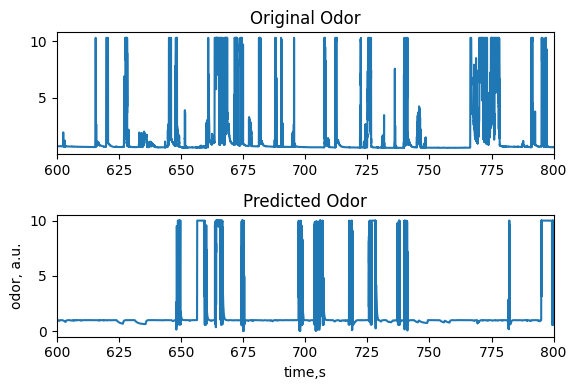

In [73]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(2000,2100)
limit = (600,800)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

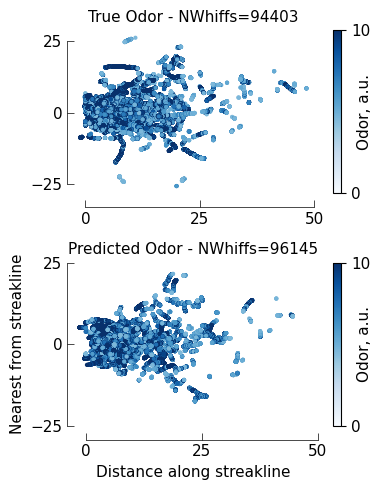

In [74]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))

ax[1].set_xlabel('Distance along streakline')
ax[1].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)5

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-25,0,25],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

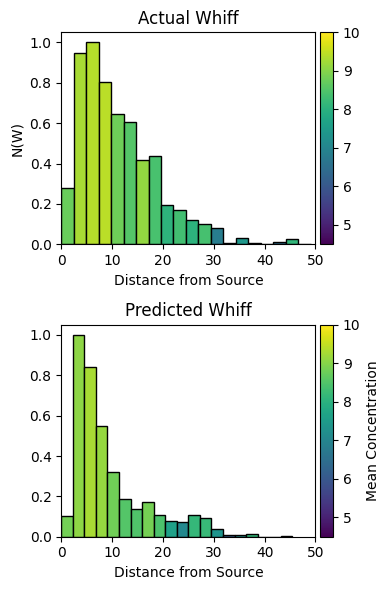

In [75]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('N(W)')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



### WHIFF STAT PLOTS

In [ ]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [ ]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

In [ ]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(odor), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

In [ ]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz', 0,1)

In [ ]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,6))
var = ax1.scatter(fdf1.avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.avg_dist_from_source,y=fdf1.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
# ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
# ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [ ]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'wd, s', 0,1)

In [ ]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var1 = ax1.scatter(fdf1.avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(odor), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [ ]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.', 0,1)

In [ ]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Standard\nDeviation (wsd)')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 3.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 3.0],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$3.0$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$3.0$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


In [ ]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,1)

In [ ]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Moving Average (wma)')
ax2.set_ylabel('wma$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [ ]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,1)

In [ ]:
import statsmodels.formula.api as smf
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf1)
fdf_predicted_new = create_class_column(fdf_predicted)



In [ ]:

lookback_time = 10

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

In [ ]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

In [ ]:
lookback_time = 10

trainset_predicted= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)

In [ ]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

In [ ]:
## whiff concentration
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC_predicted), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[1].set_xlabel('Distance from source , m')

ax[0].set_title('actual odor - WC')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)

In [ ]:
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', s=15 ,vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WF), a.u.')
# ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff Frequency')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


In [ ]:
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WD), a.u.')
# ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')
ax[0].set_title('actual odor - Whiff Duration')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


In [ ]:
### wma
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', s=15,vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WMA), a.u.')
# ax[1].set_ylabel('$\mu$(WMA)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff Moving Average')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


In [ ]:
## wsd

f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WSD), a.u.')
# ax[1].set_ylabel('$\mu$(WSD)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff SD')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
